### Import Libraries

In [8]:
import numpy as np
import sympy
from sympy import Heaviside
import random
import math
import matplotlib.pyplot as plot

In [9]:
class Stochastic_Gradient_Descent : 
    
    def __init__(self, starting_point  = [1, 1]) : 
        self.train_data = self.generate_trainingdata()
        self.x1 = starting_point[0]
        self.x2 = starting_point[1]
        self.x1_values = np.array([self.x1])
        self.x2_values = np.array([self.x2])
        self.function_values = np.array([self.f([self.x1, self.x2], self.train_data)])
        self.x_z = self.y_z = self.x_v = self.x_m = self.y_v = self.y_m = self.adam_iteration = 0
        
    def f(self, x, minibatch) : 
        # loss function sum_{w in training data} f(x,w)
        y=0; count=0
        for w in minibatch:
            z=x-w-1
            y=y+min(24*(z[0]**2+z[1]**2), (z[0]+3)**2+(z[1]+3)**2)   
            count=count+1
        return y/count
    
    def generate_trainingdata(self, m=25) : 
        return np.array([0,0])+0.25*np.random.randn(m,2)
    
    def get_derivative_value(self, x1, w1, x2, w2) :
        derivative_x1_value = (-48*w1 + 48*x1 - 48)*Heaviside(-24*(-w1 + x1 - 1)**2 + (-w1 + x1 + 2)**2 - 24*(-w2 + x2 - 1)**2 + (-w2 + x2 + 2)**2) + (-2*w1 + 2*x1 + 4)*Heaviside(24*(-w1 + x1 - 1)**2 - (-w1 + x1 + 2)**2 + 24*(-w2 + x2 - 1)**2 - (-w2 + x2 + 2)**2)
        derivative_x2_value = (-48*w2 + 48*x2 - 48)*Heaviside(-24*(-w1 + x1 - 1)**2 + (-w1 + x1 + 2)**2 - 24*(-w2 + x2 - 1)**2 + (-w2 + x2 + 2)**2) + (-2*w2 + 2*x2 + 4)*Heaviside(24*(-w1 + x1 - 1)**2 - (-w1 + x1 + 2)**2 + 24*(-w2 + x2 - 1)**2 - (-w2 + x2 + 2)**2)
        return derivative_x1_value, derivative_x2_value
    
    def get_batch_derivative(self, x1, x2, sample_batch) : 
        sum_derivative_x1_value = 0
        sum_derivative_x2_value = 0
        
        for w1, w2 in sample_batch : 
            derivative_x1_value, derivative_x2_value = self.get_derivative_value(x1, w1, x2, w2)
            sum_derivative_x1_value += derivative_x1_value
            sum_derivative_x2_value += derivative_x2_value
        
        batch_derivative_x1_value = sum_derivative_x1_value / len(sample_batch)
        batch_derivative_x2_value = sum_derivative_x2_value / len(sample_batch)
        
        return batch_derivative_x1_value, batch_derivative_x2_value
    
    
    def execute_stochastic_gradient_descent(self, gradient_descent_type = 'Constant', alpha = 0.1, beta = 0.9, beta2 = 0.999, batch_size = 10) :
        
        np.random.shuffle(self.train_data)
        for j in range(0, len(self.train_data), batch_size) : 
            
            if (j + batch_size) > len(self.train_data) : 
                continue
            
            if gradient_descent_type == 'Constant Step Size' : 
                self.x1, self.x2 = self.execute_constant_size_gradient_descent(self.train_data[j : (j + batch_size)], alpha)
                
            elif gradient_descent_type == 'Polyak' : 
                self.x1, self.x2 = self.execute_polyak_gradient_descent(self.train_data[j : (j + batch_size)])
            
            elif gradient_descent_type == 'RMSProp':
                self.x1, self.x2 = self.execute_rmsprop_gradient_descent(self.train_data[j : (j + batch_size)], alpha, beta)
                
            elif gradient_descent_type == 'HeavyBall':
                self.x1, self.x2 = self.execute_heavyball_gradient_descent(self.train_data[j : (j + batch_size)], alpha, beta)
            
            elif gradient_descent_type == 'Adam':
                self.x1, self.x2 = self.execute_adam_gradient_descent(self.train_data[j : (j + batch_size)], alpha, beta, beta2)
             
                
        self.x1_values = np.append(self.x1_values, [self.x1], axis = 0)
        self.x2_values = np.append(self.x2_values, [self.x2], axis = 0)
        self.function_values = np.append(self.function_values, [self.f([self.x1, self.x2], self.train_data)])
        
        return self.x1_values, self.x2_values, self.function_values
    
    def execute_constant_size_gradient_descent(self, sample_batch, alpha) : 
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        self.x1 -= alpha * batch_derivative_x1
        self.x2 -= alpha * batch_derivative_x2
        return self.x1, self.x2
    
    def execute_polyak_gradient_descent(self, sample_batch) : 
        epsilon = 1e-8
        numerator = self.f([self.x1, self.x2], sample_batch)
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        denominator = ((batch_derivative_x1) **2 + (batch_derivative_x2) ** 2) + epsilon
        step =  (numerator / denominator) if denominator !=0  else 0
        self.x1 = self.x1 - step * batch_derivative_x1
        self.x2 = self.x2 - step * batch_derivative_x2
        
        return self.x1, self.x2
    
    def execute_rmsprop_gradient_descent(self, sample_batch, alpha, beta) : 
        epsilon = 1e-8
        x_alpha = alpha
        y_alpha = alpha
        x_sum = 0
        y_sum = 0

        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        x_sum = (x_sum * beta) + ((1 - beta) * ((batch_derivative_x1) ** 2))
        y_sum = (y_sum * beta) + ((1 - beta) * ((batch_derivative_x2) ** 2))

        x_alpha = alpha / (math.sqrt(x_sum) + epsilon)
        y_alpha = alpha / (math.sqrt(y_sum) + epsilon)

        self.x1 = self.x1 - (x_alpha * batch_derivative_x1)
        self.x2 = self.x2 - (y_alpha * batch_derivative_x2)


        return self.x1, self.x2
    
    def execute_heavyball_gradient_descent(self, sample_batch, alpha, beta) :
        epsilon = 1e-8
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)
        self.x_z = (self.x_z * beta) + (alpha * batch_derivative_x1)
        self.y_z = (self.y_z * beta) + (alpha * batch_derivative_x2)

        self.x1 = self.x1 - self.x_z
        self.x2 = self.x2 - self.y_z

        return self.x1, self.x2
    
    def execute_adam_gradient_descent(self, sample_batch, alpha, beta_1, beta_2) : 
        epsilon = 1e-8
        
        batch_derivative_x1, batch_derivative_x2 = self.get_batch_derivative(self.x1, self.x2, sample_batch)

        self.x_m = (self.x_m * beta_1) + ((1 - beta_1) * batch_derivative_x1)
        self.y_m = (self.y_m * beta_1) + ((1 - beta_1) * batch_derivative_x2)

        self.x_v = (self.x_v * beta_2) + ((1 - beta_2) * ((batch_derivative_x1) ** 2))
        self.y_v = (self.y_v * beta_2) + ((1 - beta_2) * ((batch_derivative_x2) ** 2))

        x_m_hat = self.x_m / (1 - beta_1 ** self.adam_iteration + 1)
        y_m_hat = self.y_m / (1 - beta_1 ** self.adam_iteration + 1)

        x_v_hat = self.x_v / (1 - beta_2 ** self.adam_iteration + 1)               
        y_v_hat = self.y_v / (1 - beta_2 ** self.adam_iteration + 1)

        x_alpha = x_m_hat / (math.sqrt(x_v_hat) + epsilon)
        y_alpha = y_m_hat / (math.sqrt(y_v_hat) + epsilon)

        self.x1 = self.x1 - (x_alpha * alpha)
        self.x2 = self.x2 - (y_alpha * alpha)
        
        self.adam_iteration += 1
    
        return self.x1, self.x2
    
   

### Question c(i): Polyak with SGD

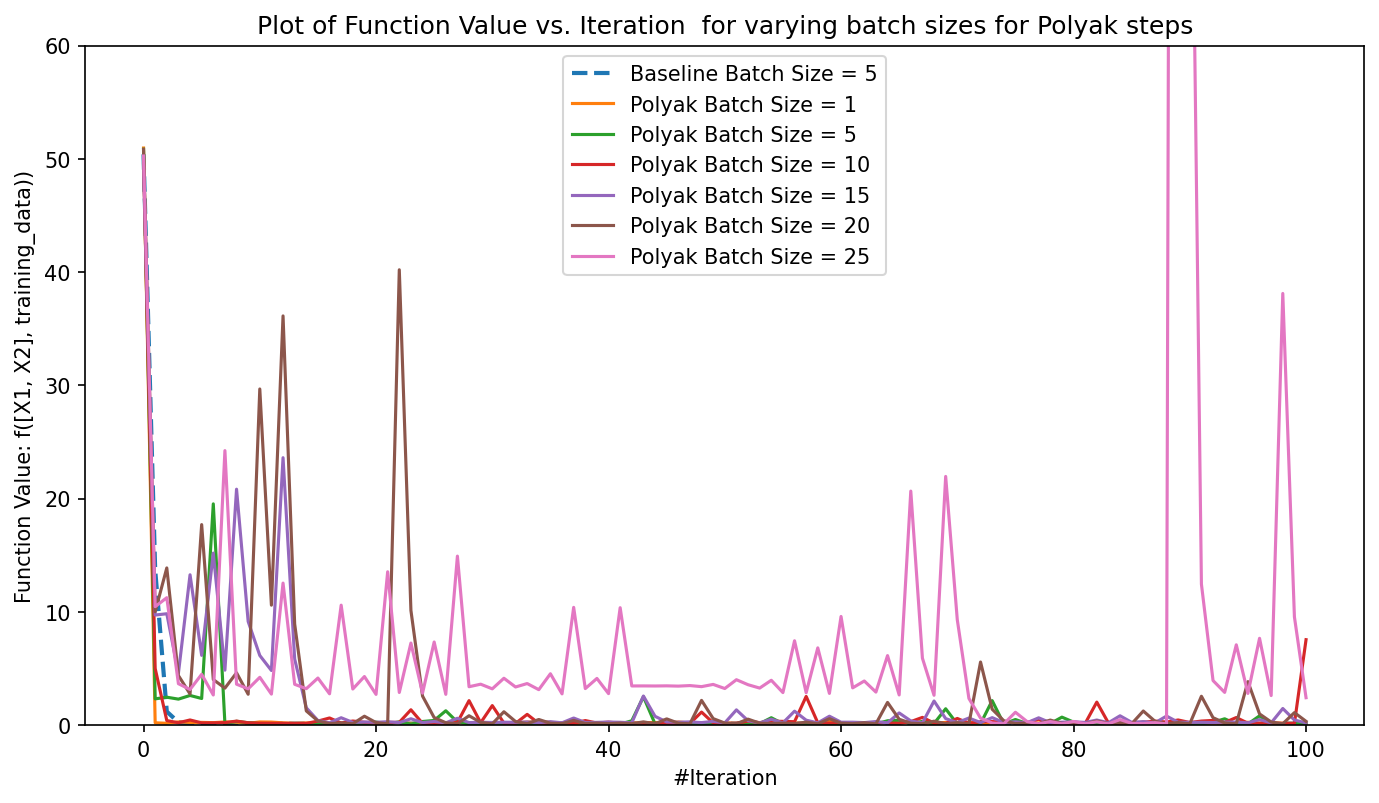

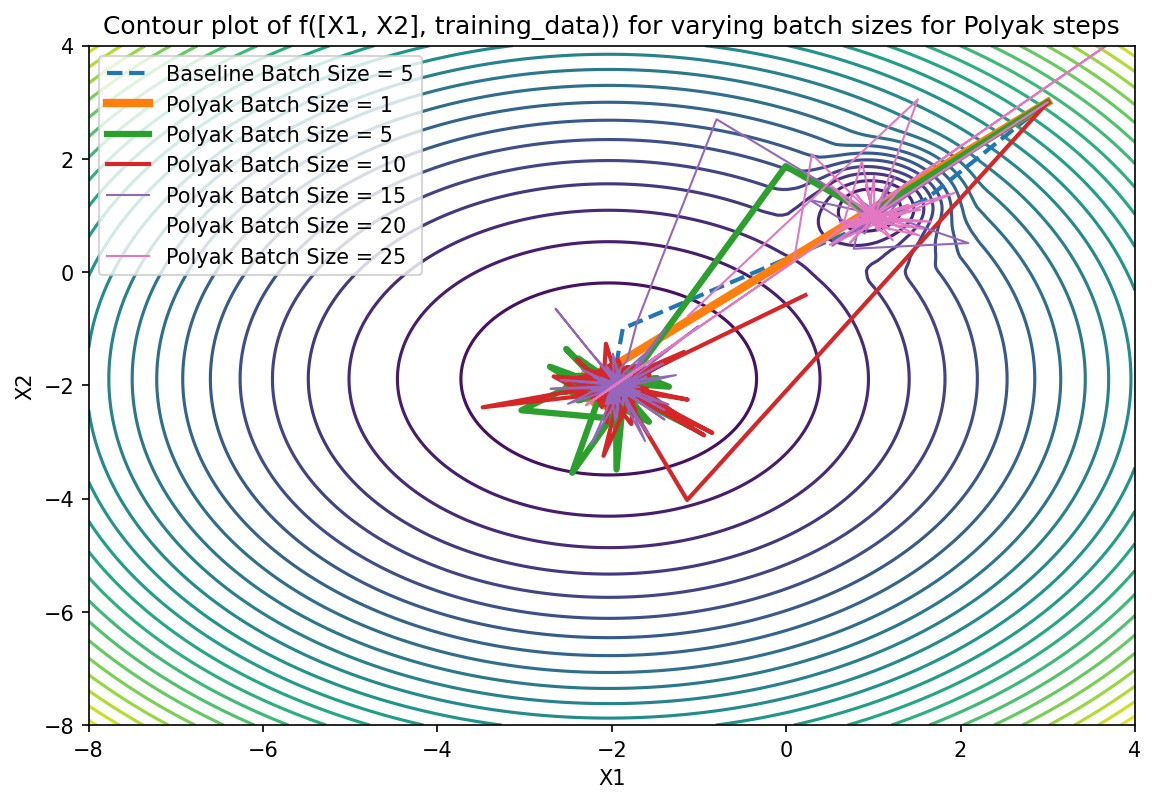

In [3]:
baseline_alpha = 0.1
baseline_batch_size = 5
number_of_iterations = 100


plot.figure(figsize=(11, 6), dpi=150)
x1, x2, f = [], [], []

##Baseline
constant_step_size_sgd = Stochastic_Gradient_Descent([3, 3])
contour_polyak_plot_params = {}
for _ in range(number_of_iterations):
    x1_values, x2_values, function_values = constant_step_size_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Constant Step Size', alpha = baseline_alpha, batch_size = baseline_batch_size)
x1.append(x1_values)
x2.append(x2_values)
f.append(function_values)
plot.plot(range(number_of_iterations + 1), function_values, lw = 2, linestyle='dashed',  label = f'Baseline Batch Size = 5')
contour_polyak_plot_params['Baseline'] = (x1, x2, f)


## Polyak
batch_sizes = [1, 5, 10, 15, 20, 25]
for batch_size in batch_sizes : 
    x1, x2, f = [], [], []
    polyak_sgd = Stochastic_Gradient_Descent([3, 3])
    
    for _ in range(number_of_iterations):
        x1_values, x2_values, function_values = polyak_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Polyak', batch_size = batch_size)
    x1.append(x1_values)
    x2.append(x2_values)
    f.append(function_values)
    
    plot.plot(range(number_of_iterations + 1), function_values, label = f'Polyak Batch Size = {batch_size}')
    contour_polyak_plot_params[batch_size] = (x1, x2, f)
plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying batch sizes for Polyak steps') 
#plot.yscale("log")
plot.legend()
plot.show()

## Contour Plot
x1 = np.linspace(-8, 4, 200)
x2 = np.linspace(-8, 4, 200)
line_thickness = 5
f = []
training_data = polyak_sgd.generate_trainingdata()

for x1_point in x1 : 
    data_point = []
    for x2_point in x2 : 
        data_point.append(polyak_sgd.f([x1_point, x2_point], training_data))
    f.append(data_point)
f_x1_x2 = np.array(f)
X1, X2 = np.meshgrid(x1, x2)

plot.figure(figsize=(9, 6), dpi=150)     
plot.contour(X1, X2, f_x1_x2, levels=25)

for batch_size in contour_polyak_plot_params : 
    x1, x2, f = contour_polyak_plot_params[batch_size]
    if batch_size == 'Baseline' : 
        plot.plot(x1[0], x2[0], lw = 2, linestyle = 'dashed', label = f'Baseline Batch Size = 5')
    else : 
        plot.plot(x1[0], x2[0], lw = line_thickness, label = f'Polyak Batch Size = {batch_size}')
    line_thickness -= 1

plot.ylim([-8, 4])
plot.xlim([-8, 4])
plot.xlabel('X1')        
plot.ylabel('X2')
plot.legend()
plot.title('Contour plot of f([X1, X2], training_data)) for varying batch sizes for Polyak steps')
plot.show()

### Question c(ii): RMSProp with SGD

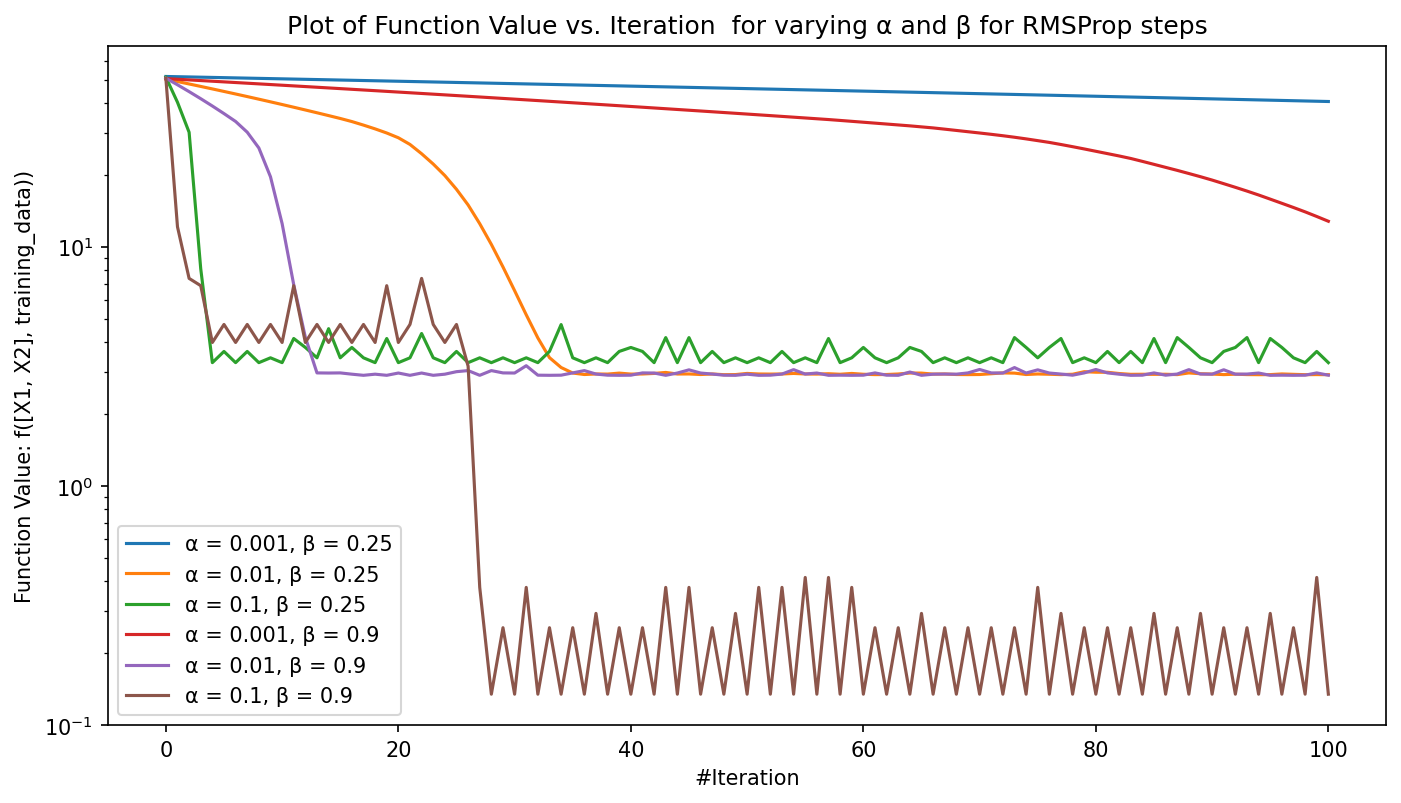

In [10]:
plot.figure(figsize=(11, 6), dpi=150)
## RMSProp
alpha_range = [0.001, 0.01, 0.1]
number_of_iterations = 100
baseline_batch_size = 5
beta_range = [0.25, 0.9]
for beta in beta_range :
    for alpha in alpha_range : 
        rmsprop_sgd = Stochastic_Gradient_Descent([3, 3])
        for _ in range(number_of_iterations):
            x1_values, x2_values, function_values = rmsprop_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'RMSProp', alpha = alpha, beta = beta, batch_size = baseline_batch_size)

        plot.plot(range(number_of_iterations + 1), function_values, label = f'α = {alpha}, β = {beta}')
        
#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying α and β for RMSProp steps') 
plot.yscale("log")
plot.legend()
plot.show()



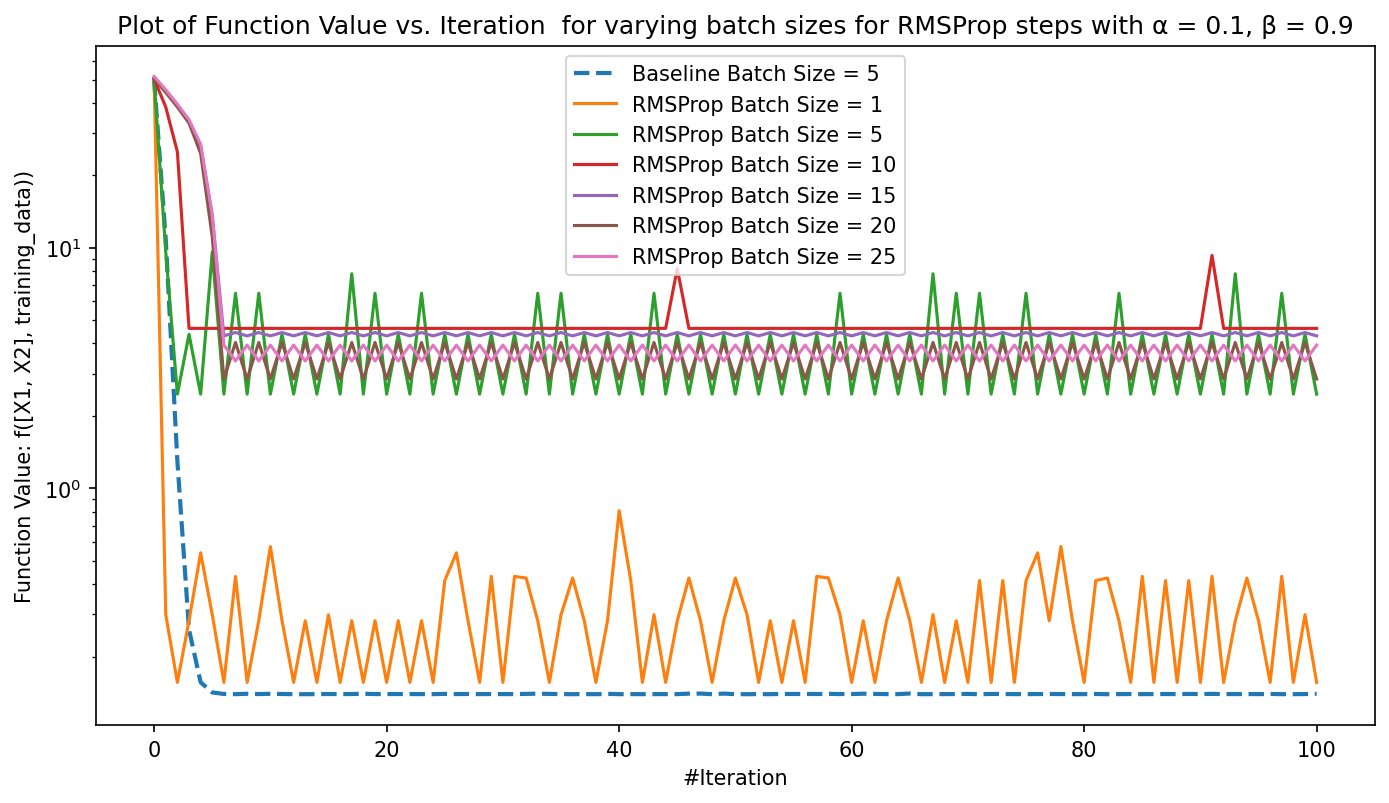

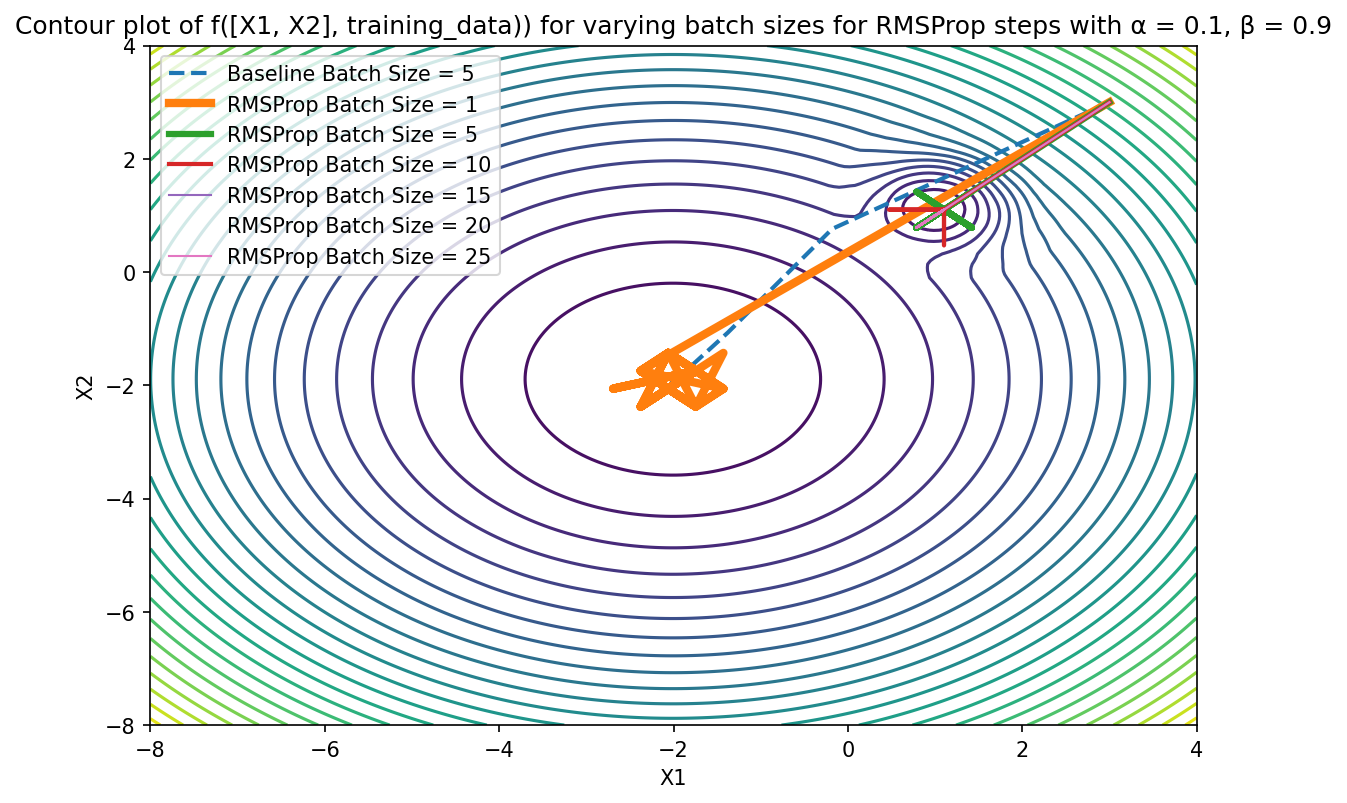

In [12]:
baseline_alpha = 0.1
baseline_batch_size = 5
number_of_iterations = 100


plot.figure(figsize=(11, 6), dpi=150)
x1, x2, f = [], [], []

##Baseline
constant_step_size_sgd = Stochastic_Gradient_Descent([3, 3])
contour_polyak_plot_params = {}
for _ in range(number_of_iterations):
    x1_values, x2_values, function_values = constant_step_size_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Constant Step Size', alpha = baseline_alpha, batch_size = baseline_batch_size)
x1.append(x1_values)
x2.append(x2_values)
f.append(function_values)
plot.plot(range(number_of_iterations + 1), function_values, lw = 2, linestyle='dashed',  label = f'Baseline Batch Size = 5')
contour_polyak_plot_params['Baseline'] = (x1, x2, f)


## RMSProp
batch_sizes = [1, 5, 10, 15, 20, 25]
optimised_alpha = 0.1
optimised_beta = 0.9
for batch_size in batch_sizes : 
    x1, x2, f = [], [], []
    rmsprop_sgd = Stochastic_Gradient_Descent([3, 3])
    
    for _ in range(number_of_iterations):
        x1_values, x2_values, function_values = rmsprop_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'RMSProp', alpha = optimised_alpha, beta = optimised_beta, batch_size = batch_size)

    x1.append(x1_values)
    x2.append(x2_values)
    f.append(function_values)
    
    plot.plot(range(number_of_iterations + 1), function_values, label = f'RMSProp Batch Size = {batch_size}')
    contour_polyak_plot_params[batch_size] = (x1, x2, f)
#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying batch sizes for RMSProp steps with α = 0.1, β = 0.9') 
plot.yscale("log")
plot.legend()
plot.show()

## Contour Plot
x1 = np.linspace(-8, 4, 200)
x2 = np.linspace(-8, 4, 200)
line_thickness = 5
f = []
training_data = rmsprop_sgd.generate_trainingdata()

for x1_point in x1 : 
    data_point = []
    for x2_point in x2 : 
        data_point.append(rmsprop_sgd.f([x1_point, x2_point], training_data))
    f.append(data_point)
f_x1_x2 = np.array(f)
X1, X2 = np.meshgrid(x1, x2)

plot.figure(figsize=(9, 6), dpi=150)     
plot.contour(X1, X2, f_x1_x2, levels=25)

for batch_size in contour_polyak_plot_params : 
    x1, x2, f = contour_polyak_plot_params[batch_size]
    if batch_size == 'Baseline' : 
        plot.plot(x1[0], x2[0], lw = 2, linestyle = 'dashed', label = f'Baseline Batch Size = 5')
    else : 
        plot.plot(x1[0], x2[0], lw = line_thickness, label = f'RMSProp Batch Size = {batch_size}')
    line_thickness -= 1

plot.ylim([-8, 4])
plot.xlim([-8, 4])
plot.xlabel('X1')        
plot.ylabel('X2')
plot.legend()
plot.title('Contour plot of f([X1, X2], training_data)) for varying batch sizes for RMSProp steps with α = 0.1, β = 0.9')
plot.show()

### Question c(iii): Heavy Ball with SGD

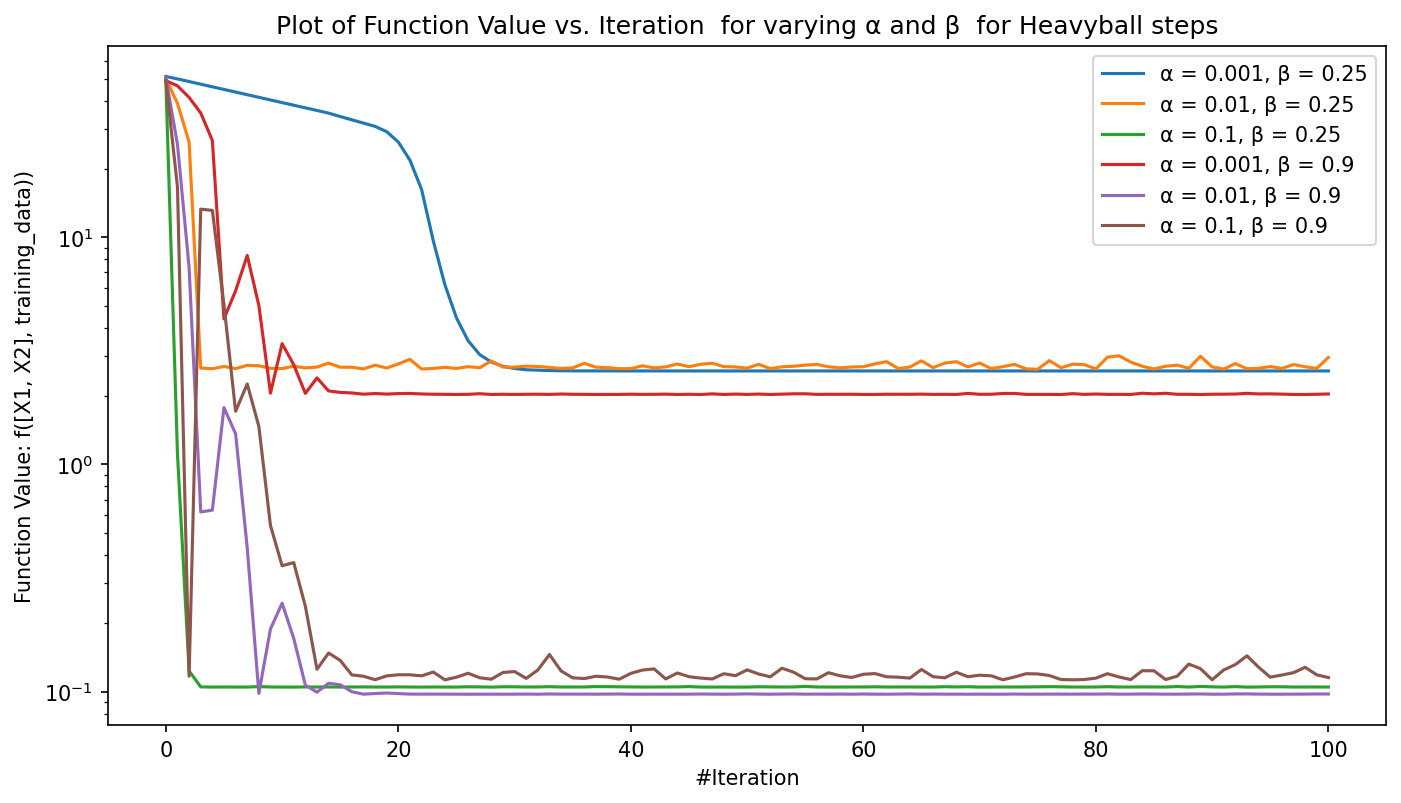

In [13]:
plot.figure(figsize=(11, 6), dpi=150)
## Heavyball
alpha_range = [0.001, 0.01, 0.1]
beta_range = [0.25, 0.9]
for beta in beta_range :
    for alpha in alpha_range : 
        heavyball_sgd = Stochastic_Gradient_Descent([3, 3])
        for _ in range(number_of_iterations):
            x1_values, x2_values, function_values = heavyball_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'HeavyBall', alpha = alpha, beta = beta, batch_size = 5)

        plot.plot(range(number_of_iterations + 1), function_values, label = f'α = {alpha}, β = {beta}')

#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying α and β  for Heavyball steps') 
plot.yscale("log")
plot.legend()
plot.show()



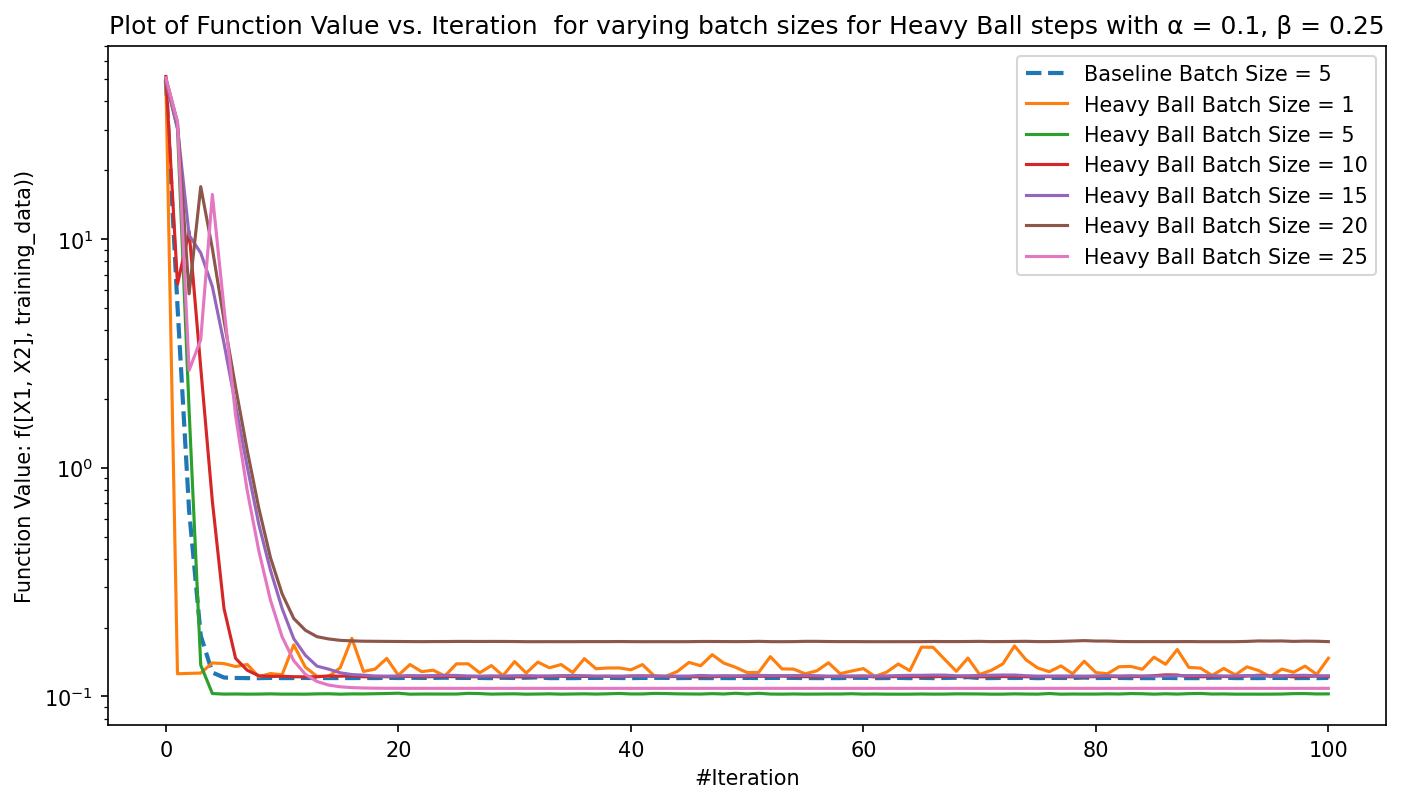

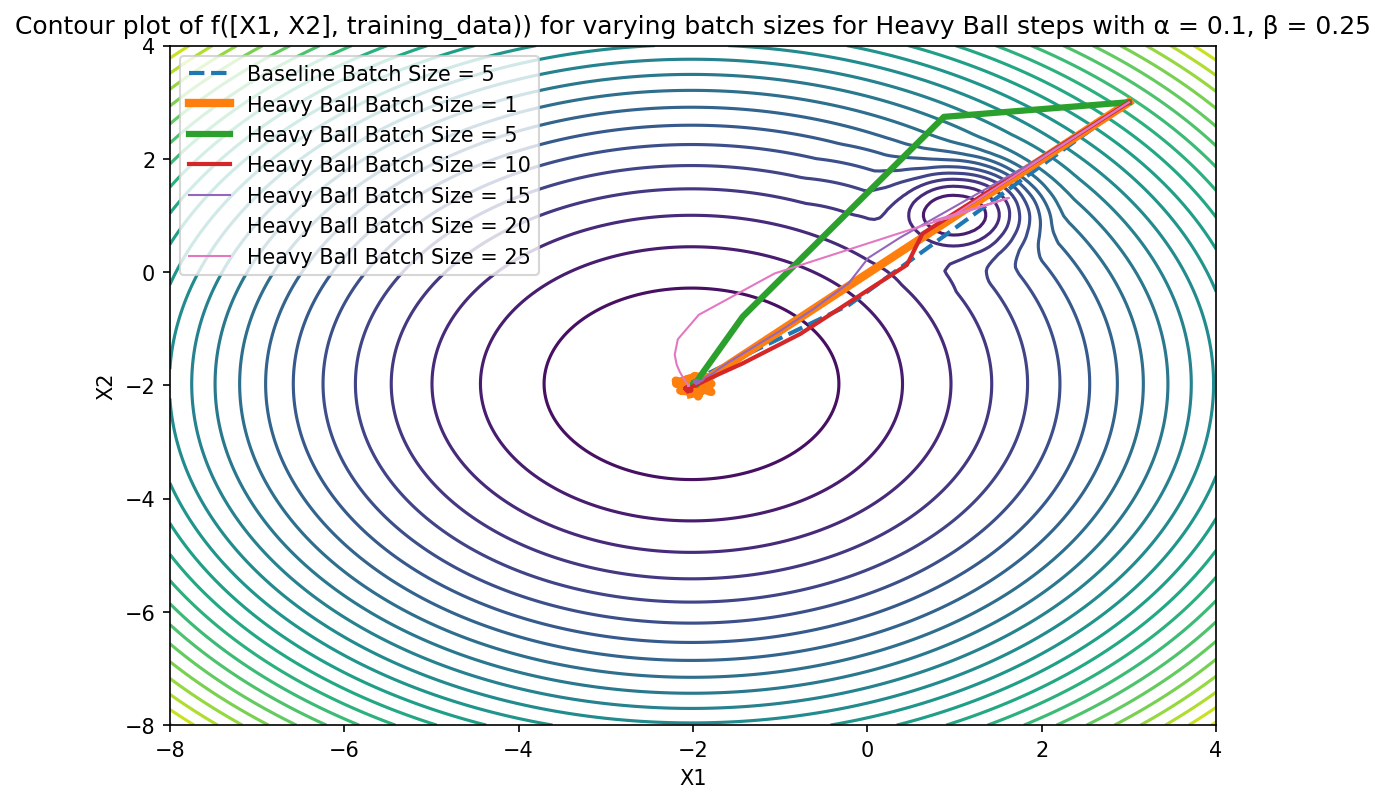

In [14]:
baseline_alpha = 0.1
baseline_batch_size = 5
number_of_iterations = 100


plot.figure(figsize=(11, 6), dpi=150)
x1, x2, f = [], [], []

##Baseline
constant_step_size_sgd = Stochastic_Gradient_Descent([3, 3])
contour_polyak_plot_params = {}
for _ in range(number_of_iterations):
    x1_values, x2_values, function_values = constant_step_size_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Constant Step Size', alpha = baseline_alpha, batch_size = baseline_batch_size)
x1.append(x1_values)
x2.append(x2_values)
f.append(function_values)
plot.plot(range(number_of_iterations + 1), function_values, lw = 2, linestyle='dashed',  label = f'Baseline Batch Size = 5')
contour_polyak_plot_params['Baseline'] = (x1, x2, f)


## Heavyball
batch_sizes = [1, 5, 10, 15, 20, 25]
optimised_alpha = 0.1
optimised_beta = 0.25
for batch_size in batch_sizes : 
    x1, x2, f = [], [], []
    heavyball_sgd = Stochastic_Gradient_Descent([3, 3])
    
    for _ in range(number_of_iterations):
        x1_values, x2_values, function_values = heavyball_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'HeavyBall', alpha = optimised_alpha, beta = optimised_beta, batch_size = batch_size)

    x1.append(x1_values)
    x2.append(x2_values)
    f.append(function_values)
    
    plot.plot(range(number_of_iterations + 1), function_values, label = f'Heavy Ball Batch Size = {batch_size}')
    contour_polyak_plot_params[batch_size] = (x1, x2, f)
#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying batch sizes for Heavy Ball steps with α = 0.1, β = 0.25') 
plot.yscale("log")
plot.legend()
plot.show()

## Contour Plot
x1 = np.linspace(-8, 4, 200)
x2 = np.linspace(-8, 4, 200)
line_thickness = 5
f = []
training_data = heavyball_sgd.generate_trainingdata()

for x1_point in x1 : 
    data_point = []
    for x2_point in x2 : 
        data_point.append(heavyball_sgd.f([x1_point, x2_point], training_data))
    f.append(data_point)
f_x1_x2 = np.array(f)
X1, X2 = np.meshgrid(x1, x2)

plot.figure(figsize=(9, 6), dpi=150)     
plot.contour(X1, X2, f_x1_x2, levels=25)

for batch_size in contour_polyak_plot_params : 
    x1, x2, f = contour_polyak_plot_params[batch_size]
    if batch_size == 'Baseline' : 
        plot.plot(x1[0], x2[0], lw = 2, linestyle = 'dashed', label = f'Baseline Batch Size = 5')
    else : 
        plot.plot(x1[0], x2[0], lw = line_thickness, label = f'Heavy Ball Batch Size = {batch_size}')
    line_thickness -= 1

plot.ylim([-8, 4])
plot.xlim([-8, 4])
plot.xlabel('X1')        
plot.ylabel('X2')
plot.legend()
plot.title('Contour plot of f([X1, X2], training_data)) for varying batch sizes for Heavy Ball steps with α = 0.1, β = 0.25')
plot.show()

### Question c(iv): Adam with SGD

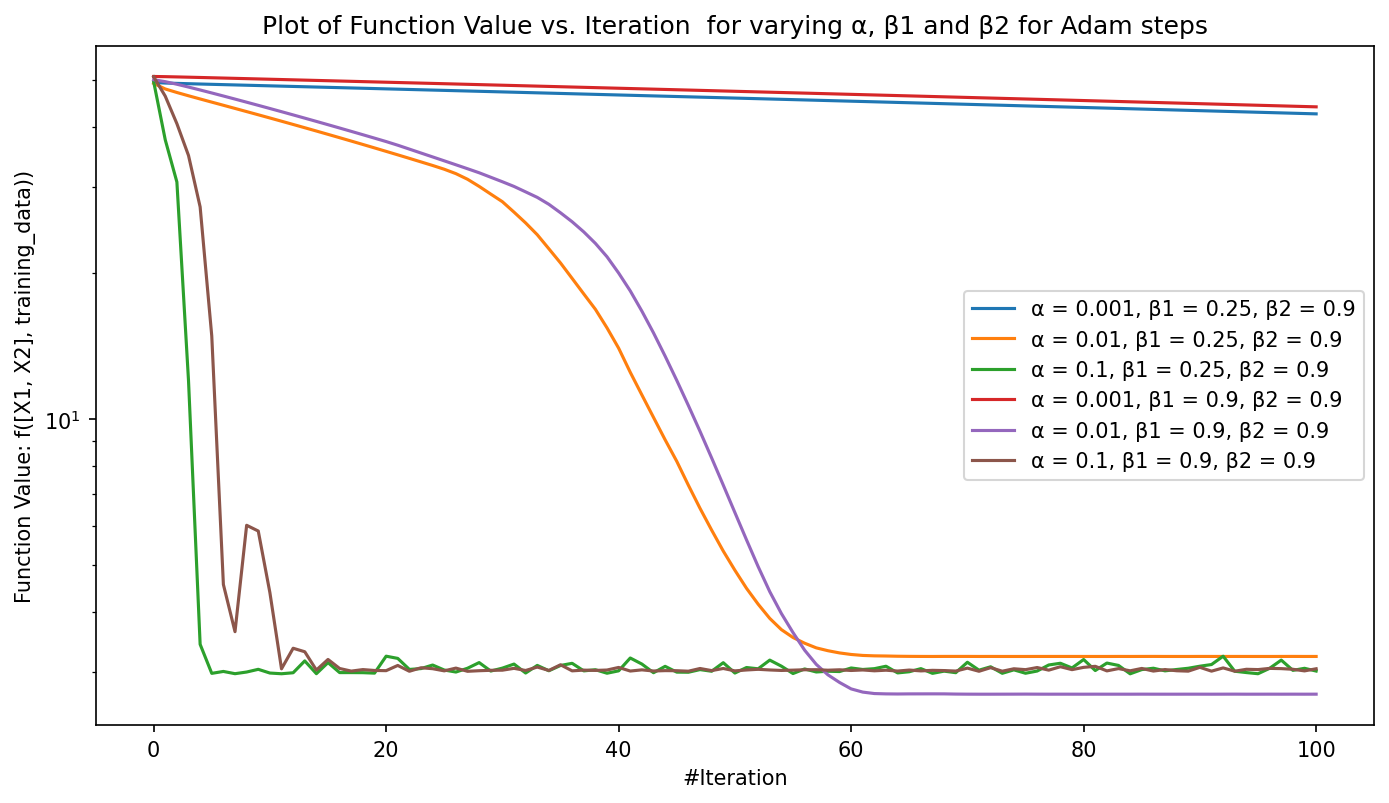

In [21]:
plot.figure(figsize=(11, 6), dpi=150)
## Adam
alpha_range = [0.001, 0.01, 0.1]
beta_range = [0.25, 0.9]
beta_2 = 0.9
for beta in beta_range :
    for alpha in alpha_range : 
        adam_sgd = Stochastic_Gradient_Descent([3, 3])
        for _ in range(number_of_iterations):
            x1_values, x2_values, function_values = adam_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Adam', alpha = alpha, beta = beta, beta2 = beta_2, batch_size = 5)

        plot.plot(range(number_of_iterations + 1), function_values, label = f'α = {alpha}, β1 = {beta}, β2 = {beta_2}')

#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying α, β1 and β2 for Adam steps') 
plot.yscale("log")
plot.legend()
plot.show()




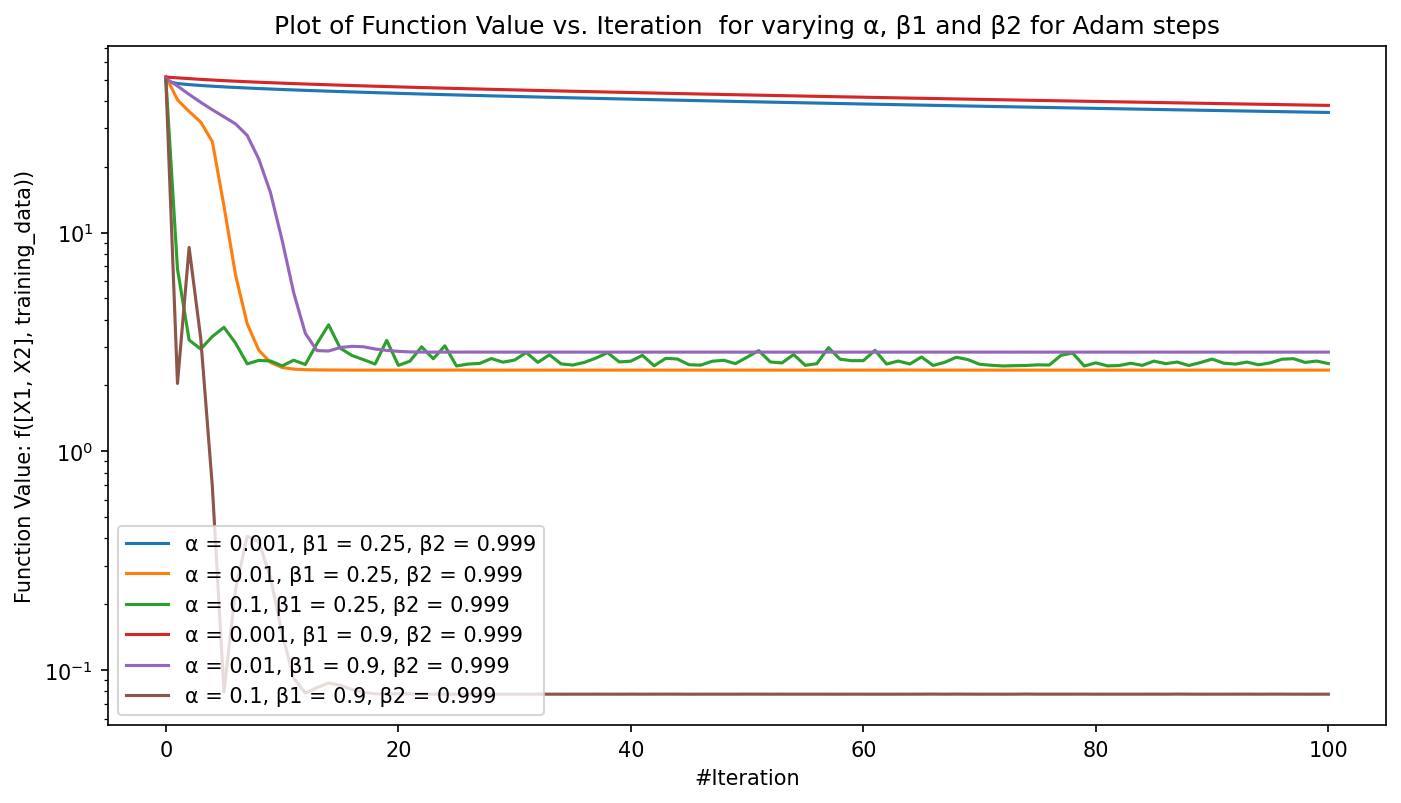

In [23]:
plot.figure(figsize=(11, 6), dpi=150)
## Adam
alpha_range = [0.001, 0.01, 0.1]
beta_range = [0.25, 0.9]
beta_2 = 0.999
for beta in beta_range :
    for alpha in alpha_range : 
        adam_sgd = Stochastic_Gradient_Descent([3, 3])
        for _ in range(number_of_iterations):
            x1_values, x2_values, function_values = adam_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Adam', alpha = alpha, beta = beta, beta2 = beta_2, batch_size = 5)

        plot.plot(range(number_of_iterations + 1), function_values, label = f'α = {alpha}, β1 = {beta}, β2 = {beta_2}')

#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying α, β1 and β2 for Adam steps') 
plot.yscale("log")
plot.legend()
plot.show()




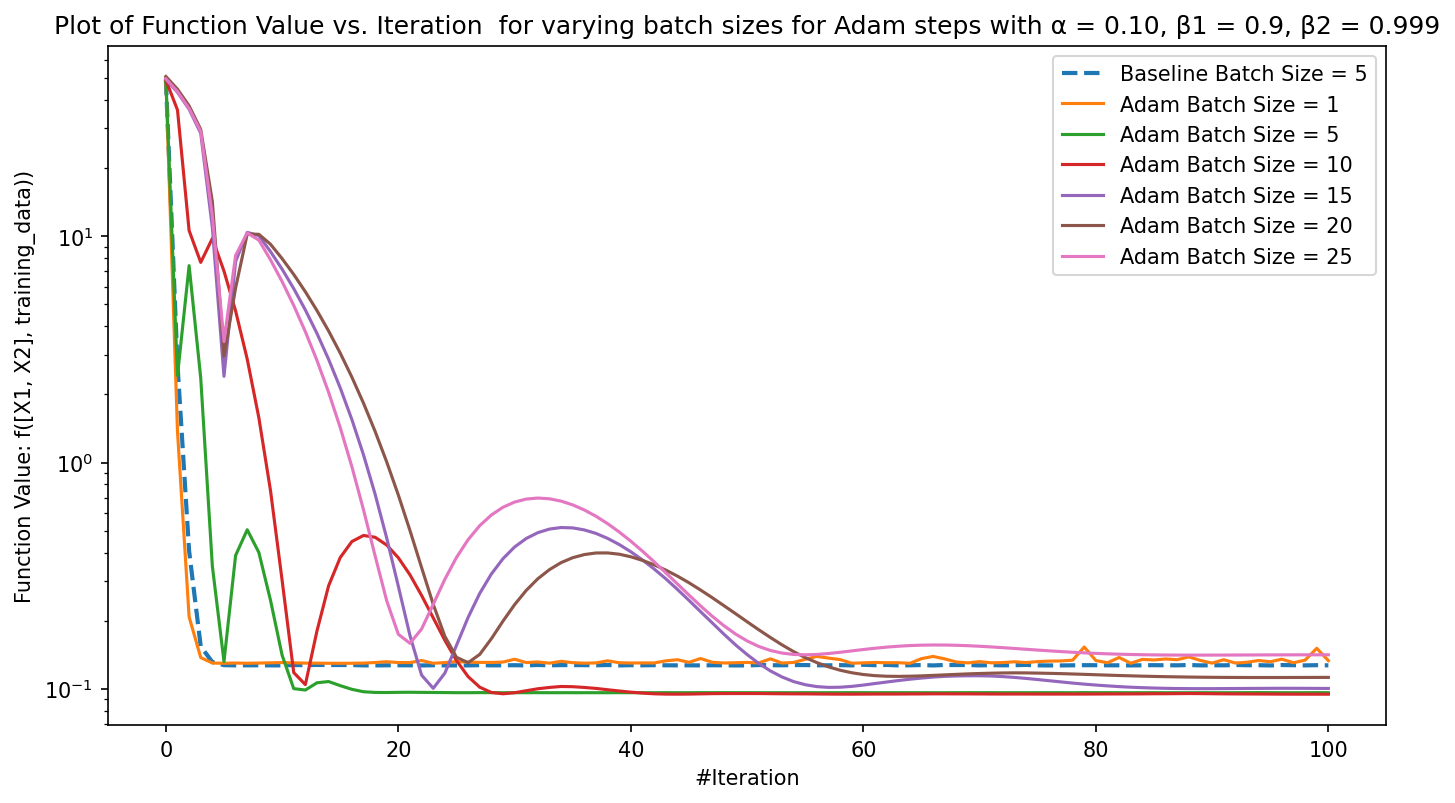

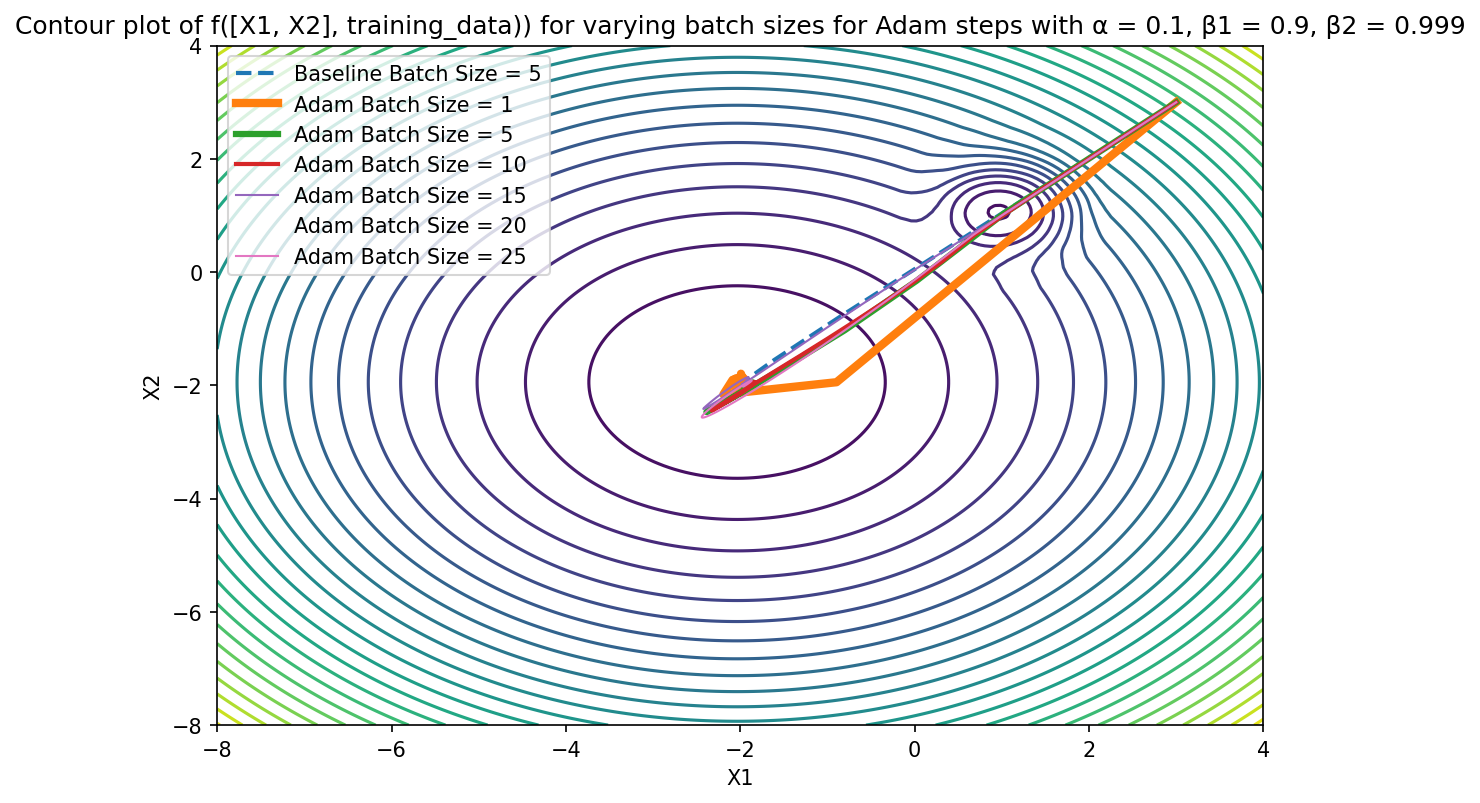

In [24]:
baseline_alpha = 0.1
baseline_batch_size = 5
number_of_iterations = 100


plot.figure(figsize=(11, 6), dpi=150)
x1, x2, f = [], [], []

##Baseline
constant_step_size_sgd = Stochastic_Gradient_Descent([3, 3])
contour_polyak_plot_params = {}
for _ in range(number_of_iterations):
    x1_values, x2_values, function_values = constant_step_size_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Constant Step Size', alpha = baseline_alpha, batch_size = baseline_batch_size)
x1.append(x1_values)
x2.append(x2_values)
f.append(function_values)
plot.plot(range(number_of_iterations + 1), function_values, lw = 2, linestyle='dashed',  label = f'Baseline Batch Size = 5')
contour_polyak_plot_params['Baseline'] = (x1, x2, f)


## Adam
batch_sizes = [1, 5, 10, 15, 20, 25]
optimised_alpha = 0.1
optimised_beta1 = 0.9
optimised_beta2 = 0.999
for batch_size in batch_sizes : 
    x1, x2, f = [], [], []
    adam_sgd = Stochastic_Gradient_Descent([3, 3])
    
    for _ in range(number_of_iterations):
        x1_values, x2_values, function_values = adam_sgd.execute_stochastic_gradient_descent(gradient_descent_type = 'Adam', alpha = optimised_alpha, beta = optimised_beta1, beta2 = optimised_beta2, batch_size = batch_size)

    x1.append(x1_values)
    x2.append(x2_values)
    f.append(function_values)
    
    plot.plot(range(number_of_iterations + 1), function_values, label = f'Adam Batch Size = {batch_size}')
    contour_polyak_plot_params[batch_size] = (x1, x2, f)
#plot.ylim([0, 60])
plot.xlabel('#Iteration')
plot.ylabel('Function Value: f([X1, X2], training_data))')
plot.title('Plot of Function Value vs. Iteration  for varying batch sizes for Adam steps with α = 0.10, β1 = 0.9, β2 = 0.999') 
plot.yscale("log")
plot.legend()
plot.show()

## Contour Plot
x1 = np.linspace(-8, 4, 200)
x2 = np.linspace(-8, 4, 200)
line_thickness = 5
f = []
training_data = polyak_sgd.generate_trainingdata()

for x1_point in x1 : 
    data_point = []
    for x2_point in x2 : 
        data_point.append(polyak_sgd.f([x1_point, x2_point], training_data))
    f.append(data_point)
f_x1_x2 = np.array(f)
X1, X2 = np.meshgrid(x1, x2)

plot.figure(figsize=(9, 6), dpi=150)     
plot.contour(X1, X2, f_x1_x2, levels=25)

for batch_size in contour_polyak_plot_params : 
    x1, x2, f = contour_polyak_plot_params[batch_size]
    if batch_size == 'Baseline' : 
        plot.plot(x1[0], x2[0], lw = 2, linestyle = 'dashed', label = f'Baseline Batch Size = 5')
    else : 
        plot.plot(x1[0], x2[0], lw = line_thickness, label = f'Adam Batch Size = {batch_size}')
    line_thickness -= 1

plot.ylim([-8, 4])
plot.xlim([-8, 4])
plot.xlabel('X1')        
plot.ylabel('X2')
plot.legend()
plot.title('Contour plot of f([X1, X2], training_data)) for varying batch sizes for Adam steps with α = 0.1, β1 = 0.9, β2 = 0.999')
plot.show()